In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import dask
import os

In [2]:
#load in hfls data and also laod in lhf era5 data
e5_LH = xr.open_dataarray("/home/z5113258/Documents/data/REAN_HB/ERA5/ERA5_lhf.nc")
e5_SH = xr.open_dataarray("/home/z5113258/Documents/data/REAN_HB/ERA5/ERA5_shf.nc")
e5_SW = xr.open_dataarray("/home/z5113258/Documents/data/REAN_HB/ERA5/ERA5_swrf.nc")
e5_LW = xr.open_dataarray("/home/z5113258/Documents/data/REAN_HB/ERA5/ERA5_lwrf.nc")

            

In [3]:
outdir = '/home/z5113258/Documents/data/CMIP6_HB_new/'#dict with file names
models={}
varis = {'lw':'_netLW.nc', 'sw':'_netSW.nc', 'lhf':'_hfls.nc', 'shf':'_hfss.nc', 'qnet':'_qnet.nc'}
for model in os.listdir(outdir):
    #go thorugh all varis
    if model in ['NESM3']:
        pass
    else:
        mod={}
        for key in varis.keys():
            #input file
            inp_files = (os.path.join(outdir, model, str(model+varis[key])))
            try:
                #load in file
                var = xr.open_dataarray(inp_files)
                #put into dict
                mod[key]=var
                models[model] = mod

            except Exception as e:
                print(e)
                pass



[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_netLW.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_netSW.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_hfls.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_hfss.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_qnet.nc'


In [4]:
def get_region(da, lat, lat_r, lon, lon_r):
    DA_ss = da.sel(lat=slice(lat, lat_r),lon=slice(lon, lon_r)).mean(['lat', 'lon'])
    return DA_ss

In [5]:
for i, model in enumerate(models.keys()):
    model_hf=models[model]
    lw=model_hf['lw'].assign_coords({'model':model})
    sw=model_hf['sw'].assign_coords({'model':model})
    sh=model_hf['shf'].assign_coords({'model':model})
    lh=model_hf['lhf'].assign_coords({'model':model})
    q=(lw+sw-lh-sh)#terms are all positive so have to add in sign, and scale to degC/month

    #q=model_hf['qnet'].assign_coords({'model':model})
    #q = q*3986*1026*50
    #now turn all these variables into an array
    if i == 0:
        lwm = lw
        swm = sw
        shm = sh
        lhm = lh
        qm = q
    else:
        lwm = xr.concat([lwm, lw], dim = 'model')
        swm = xr.concat([swm, sw], dim = 'model')
        shm = xr.concat([shm, sh], dim = 'model')
        lhm = xr.concat([lhm, lh], dim = 'model')
        qm = xr.concat([qm, q], dim = 'model')
        


In [6]:
def IQR_plot(vari,d, lat, lat1, lon, lon1):
    V, label = var_titles[vari]
    axs[d].fill_between(range(1,13), get_region(((V.quantile(0.25, 'model'))),  lat, lat1, lon, lon1),
                      get_region(((V.quantile(0.75, 'model'))),  lat, lat1, lon, lon1), 
                      alpha = 0.25)
    return

In [7]:
def median_plt(vari,d, lat, lat1, lon, lon1):
    V, label = var_titles[vari]
    axs[d].plot(range(1,13), get_region(V.median('model'), lat, lat1, lon, lon1), label = label)
    return

In [8]:
def obs_plt(vari,d, lat, lat1, lon, lon1):
    V, label, col = var_titles[vari]
    axs[d].plot(range(1,13), get_region(V, lat, lat1, lon, lon1), label = label, ls = '--', c = col)
    return

In [9]:
def plt_HF_reg(lat, lat1, lon, lon1):
    plt.figure(figsize = (10,16))
    get_region(lwm, lat, lat1, lon, lon1).median('model').plot(label = 'CMIP6 MMM Longwave')
    IQR_plot(lwm, lat, lat1, lon, lon1)
    get_region(swm, lat, lat1, lon, lon1).median('model').plot(label = 'CMIP6 MMM Shortwave')
    IQR_plot(swm, lat, lat1, lon, lon1)
    get_region(-1*shm, lat, lat1, lon, lon1).median('model').plot(label = 'CMIP6 MMM Sensible')
    IQR_plot(-1*shm, lat, lat1, lon, lon1)
    get_region(-1*lhm, lat, lat1, lon, lon1).median('model').plot(label = 'CMIP6 MMM Latent')
    IQR_plot(-1*lhm, lat, lat1, lon, lon1)
    get_region((lwm+swm -shm -lhm), lat, lat1, lon, lon1).median('model').plot(label = 'CMIP6 MMM Qnet')
    IQR_plot((lwm+swm -shm -lhm), lat, lat1, lon, lon1)
    #get_region((qm), lat, lat1, lon, lon1).median('model').plot(label = 'CMIP6 MMM Qnet')
    
    
    
    get_region(e5_LW, lat, lat1, lon, lon1).plot(label = 'ERA5 Longwave', c = 'tab:blue', ls = '--')
    get_region(e5_SW, lat, lat1, lon, lon1).plot(label = 'ERA5 Shortwave', c= 'tab:orange', ls = '--')
    get_region(e5_SH, lat, lat1, lon, lon1).plot(label = 'ERA5 Sensible', c = 'tab:green', ls = '--')
    get_region(e5_LH, lat, lat1, lon, lon1).plot(label = 'ERA5 Latent', c= 'tab:red', ls = '--')
    get_region((e5_LW+e5_SW +e5_SH +e5_LH), lat, lat1, lon, lon1).plot(label = 'ERA5 Qnet', c= 'tab:purple', ls = '--')

    plt.legend(bbox_to_anchor=(1.1, 1.05))
    return

In [10]:
var_titles={'LW':[lwm,'CMIP6 MMM Longwave'], 'SW':[swm, 'CMIP6 MMM Shortwave'], 'SH':[-1*shm, 'CMIP6 MMM Sensible heat'], 
            'LH':[-1*lhm, 'CMIP6 MMM Latent heat'], 'Q':[(lwm+swm -shm -lhm), 'CMIP6 MMM Qnet'],
           'eLW':[e5_LW,'ERA5 Longwave', 'tab:blue'], 'eSW':[e5_SW, 'ERA5 Shortwave', 'tab:orange'],
            'eSH':[e5_SH, 'ERA5 Sensible heat', 'tab:red'], 
            'eLH':[e5_LH, 'ERA5 Latent heat', 'tab:green'], 'eQ':[(e5_LW+e5_SW +e5_SH +e5_LH), 'ERA5 Qnet', 'tab:purple']}


In [14]:
regions = {'WTIO':('a)', -10,10,50,70), 'SETIO':('b)',-10,0,90,110),'Arabian Sea':('c)',10,20,50,70)}#, 'BOB': ('d', 10,20,80,100)}

/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/na

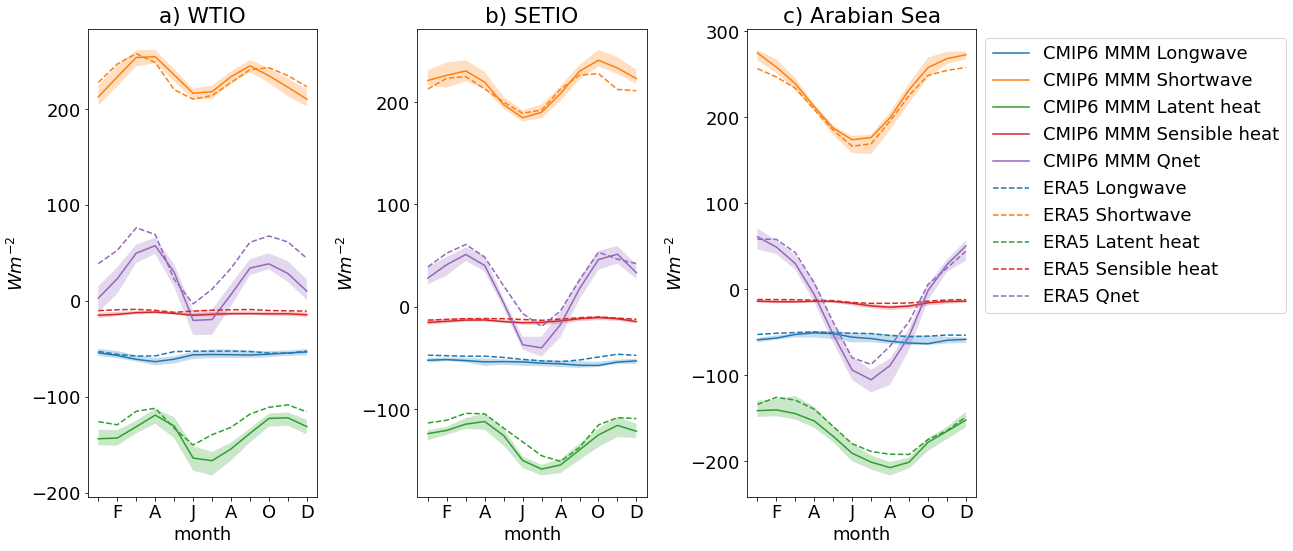

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(14, 8))
plt.rcParams['font.size'] = 18
axs = axs.ravel()
for i, reg in enumerate(regions.items()):
    lat = reg[1][1]
    lat1 = reg[1][2]
    lon = reg[1][3]
    lon1 = reg[1][4]
    median_plt('LW',i, lat,lat1,lon,lon1)
    IQR_plot('LW', i,  lat,lat1,lon,lon1)
    median_plt('SW',i, lat,lat1,lon,lon1)
    IQR_plot('SW', i,  lat,lat1,lon,lon1)
    median_plt('LH',i, lat,lat1,lon,lon1)
    IQR_plot('LH', i,  lat,lat1,lon,lon1)
    median_plt('SH',i, lat,lat1,lon,lon1)
    IQR_plot('SH', i,  lat,lat1,lon,lon1)
    median_plt('Q',i, lat,lat1,lon,lon1)
    IQR_plot('Q', i,  lat,lat1,lon,lon1)
    #now plot Obs
    obs_plt('eLW',i, lat,lat1,lon,lon1)
    obs_plt('eSW',i, lat,lat1,lon,lon1)
    obs_plt('eLH',i, lat,lat1,lon,lon1)
    obs_plt('eSH',i, lat,lat1,lon,lon1)
    obs_plt('eQ',i, lat,lat1,lon,lon1)
    axs[i].set_title(reg[1][0]+' '+reg[0])
    axs[i].set_xlabel('month',fontsize=18)
    axs[i].set_ylabel("$Wm^{-2}$", fontsize=18)
    #axs[i].set_xticks([2,4,6,8,10,12]) 
    #axs[i].set_xticklabels(['F', 'A', 'J','A','O','D'], fontsize=14)
    axs[i].set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])#, ['F', 'A', 'J','A','O','D'])
    axs[i].set_xticklabels( [' ', 'F',' ',  'A',' ', 'J',' ', 'A',' ', 'O',' ', 'D'], fontsize=18)
    plt.tight_layout()
# Create the legend|
plt.legend( bbox_to_anchor=(1, 1), loc='upper left')
#plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/F_3.svg', pad_inches = 1, bbox_inches = 'tight')
#plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/F_3.png', dpi = 300, pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')


/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/na

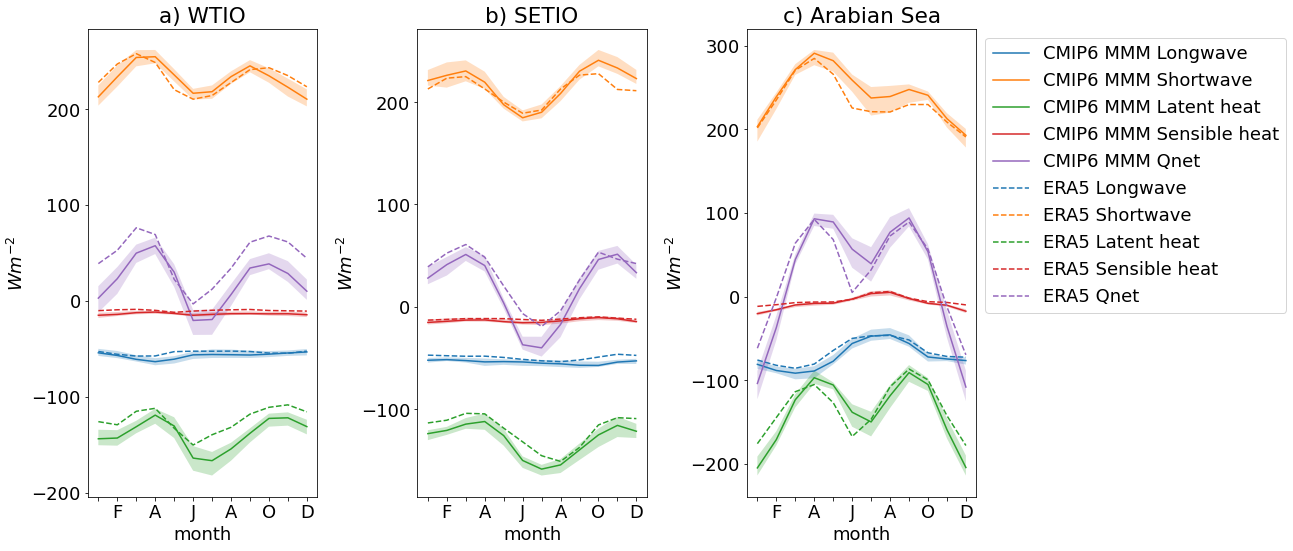

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(14, 8))
plt.rcParams['font.size'] = 18
axs = axs.ravel()
for i, reg in enumerate(regions.items()):
    lat = reg[1][1]
    lat1 = reg[1][2]
    lon = reg[1][3]
    lon1 = reg[1][4]
    median_plt('LW',i, lat,lat1,lon,lon1)
    IQR_plot('LW', i,  lat,lat1,lon,lon1)
    median_plt('SW',i, lat,lat1,lon,lon1)
    IQR_plot('SW', i,  lat,lat1,lon,lon1)
    median_plt('LH',i, lat,lat1,lon,lon1)
    IQR_plot('LH', i,  lat,lat1,lon,lon1)
    median_plt('SH',i, lat,lat1,lon,lon1)
    IQR_plot('SH', i,  lat,lat1,lon,lon1)
    median_plt('Q',i, lat,lat1,lon,lon1)
    IQR_plot('Q', i,  lat,lat1,lon,lon1)
    #now plot Obs
    obs_plt('eLW',i, lat,lat1,lon,lon1)
    obs_plt('eSW',i, lat,lat1,lon,lon1)
    obs_plt('eLH',i, lat,lat1,lon,lon1)
    obs_plt('eSH',i, lat,lat1,lon,lon1)
    obs_plt('eQ',i, lat,lat1,lon,lon1)
    axs[i].set_title(reg[1][0]+' '+reg[0])
    axs[i].set_xlabel('month',fontsize=18)
    axs[i].set_ylabel("$Wm^{-2}$", fontsize=18)
    #axs[i].set_xticks([2,4,6,8,10,12]) 
    #axs[i].set_xticklabels(['F', 'A', 'J','A','O','D'], fontsize=14)
    axs[i].set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])#, ['F', 'A', 'J','A','O','D'])
    axs[i].set_xticklabels( [' ', 'F',' ',  'A',' ', 'J',' ', 'A',' ', 'O',' ', 'D'], fontsize=18)
    plt.tight_layout()
# Create the legend|
plt.legend( bbox_to_anchor=(1, 1), loc='upper left')
#plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/F_3.svg', pad_inches = 1, bbox_inches = 'tight')
plt.savefig('/home/z5113258/Documents/figures/Figures_high_res/F_31.png', dpi = 600, pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')


/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/na

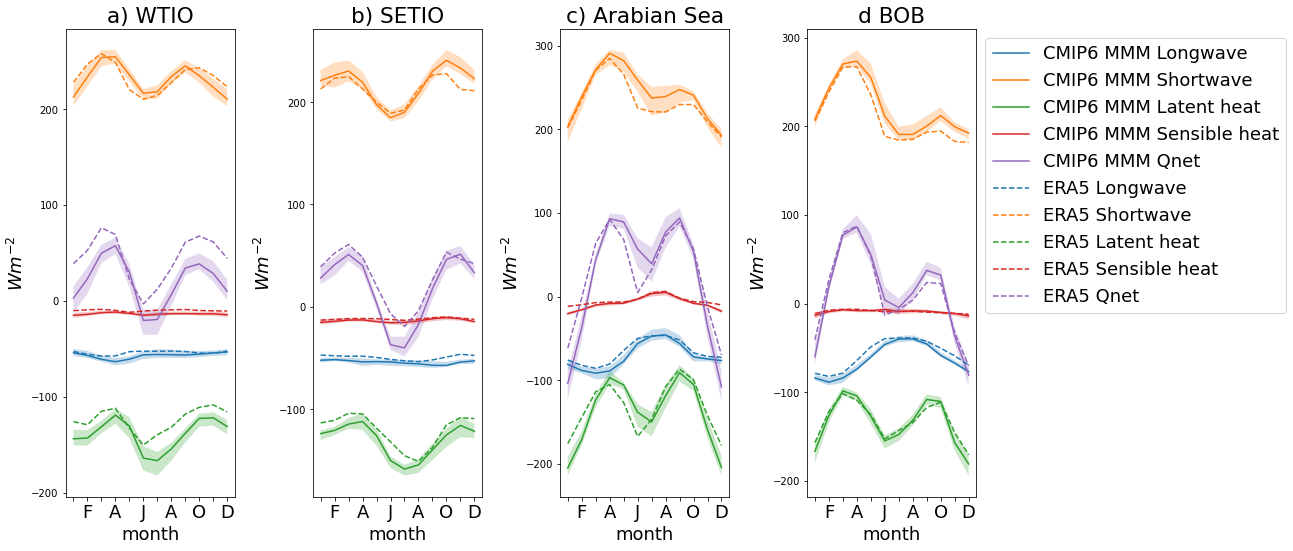

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(14, 8))
plt.rcParams['font.size'] = 18
axs = axs.ravel()
for i, reg in enumerate(regions.items()):
    lat = reg[1][1]
    lat1 = reg[1][2]
    lon = reg[1][3]
    lon1 = reg[1][4]
    median_plt('LW',i, lat,lat1,lon,lon1)
    IQR_plot('LW', i,  lat,lat1,lon,lon1)
    median_plt('SW',i, lat,lat1,lon,lon1)
    IQR_plot('SW', i,  lat,lat1,lon,lon1)
    median_plt('LH',i, lat,lat1,lon,lon1)
    IQR_plot('LH', i,  lat,lat1,lon,lon1)
    median_plt('SH',i, lat,lat1,lon,lon1)
    IQR_plot('SH', i,  lat,lat1,lon,lon1)
    median_plt('Q',i, lat,lat1,lon,lon1)
    IQR_plot('Q', i,  lat,lat1,lon,lon1)
    #now plot Obs
    obs_plt('eLW',i, lat,lat1,lon,lon1)
    obs_plt('eSW',i, lat,lat1,lon,lon1)
    obs_plt('eLH',i, lat,lat1,lon,lon1)
    obs_plt('eSH',i, lat,lat1,lon,lon1)
    obs_plt('eQ',i, lat,lat1,lon,lon1)
    axs[i].set_title(reg[1][0]+' '+reg[0])
    axs[i].set_xlabel('month',fontsize=18)
    axs[i].set_ylabel("$Wm^{-2}$", fontsize=18)
    #axs[i].set_xticks([2,4,6,8,10,12]) 
    #axs[i].set_xticklabels(['F', 'A', 'J','A','O','D'], fontsize=14)
    axs[i].set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])#, ['F', 'A', 'J','A','O','D'])
    axs[i].set_xticklabels( [' ', 'F',' ',  'A',' ', 'J',' ', 'A',' ', 'O',' ', 'D'], fontsize=18)
    plt.tight_layout()
# Create the legend|
plt.legend( bbox_to_anchor=(1, 1), loc='upper left')


In [32]:
lw = get_region(var_titles['LW'][0], 10, 20, 80, 100).median('model').mean('month')
sw = get_region(var_titles['SW'][0], 10, 20, 80, 100).median('model').mean('month')
lh = get_region(var_titles['LH'][0], 10, 20, 80, 100).median('model').mean('month')
sh = get_region(var_titles['SH'][0], 10, 20, 80, 100).median('model').mean('month')

elw = get_region(var_titles['eLW'][0], 10, 20, 80,100).mean('month')
esw = get_region(var_titles['eSW'][0], 10, 20, 80,100).mean('month')
elh = get_region(var_titles['eLH'][0], 10, 20, 80, 100).mean('month')
esh = get_region(var_titles['eSH'][0], 10, 20, 80, 100).mean('month')

In [33]:
print(elw, esw, elh, esh)

<xarray.DataArray 'msnlwrf' ()>
array(-57.559143, dtype=float32) <xarray.DataArray 'msnswrf' ()>
array(210.3232, dtype=float32) <xarray.DataArray 'mslhf' ()>
array(-132.40744, dtype=float32) <xarray.DataArray 'msshf' ()>
array(-9.167005, dtype=float32)


In [34]:
print(lw, sw, lh, sh)

<xarray.DataArray ()>
array(-62.668472, dtype=float32) <xarray.DataArray ()>
array(220.57338, dtype=float32) <xarray.DataArray 'hfls' ()>
array(-136.07542, dtype=float32) <xarray.DataArray 'hfss' ()>
array(-9.940372, dtype=float32)


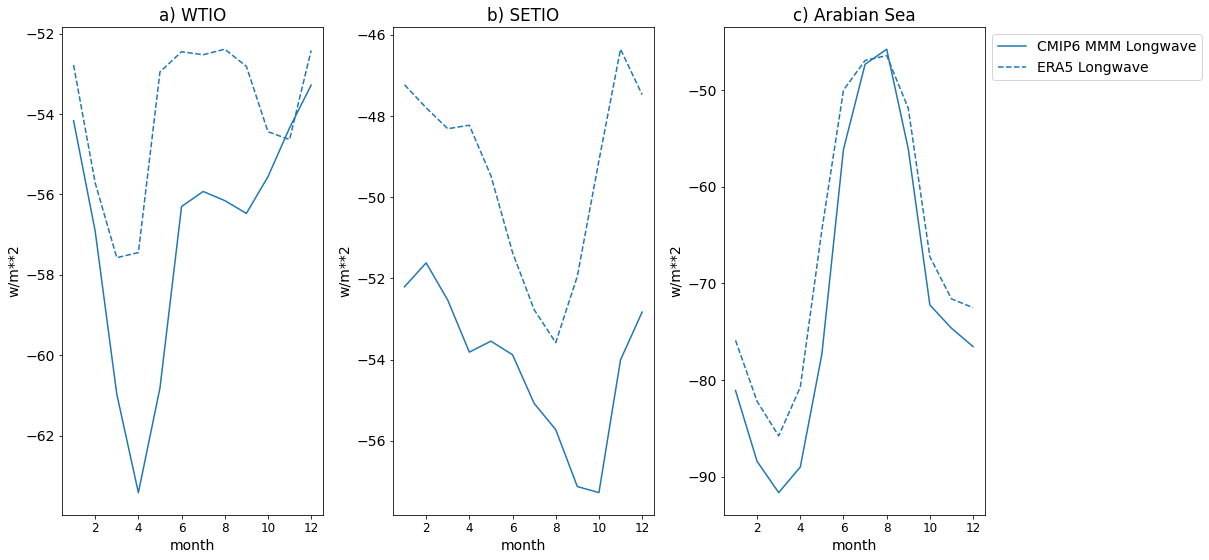

In [109]:
fig, axs = plt.subplots(1, 3, figsize=(14, 8))
plt.rcParams['font.size'] = 14
axs = axs.ravel()
for i, reg in enumerate(regions.items()):
    lat = reg[1][1]
    lat1 = reg[1][2]
    lon = reg[1][3]
    lon1 = reg[1][4]
    median_plt('LW',i, lat,lat1,lon,lon1)
    
    obs_plt('eLW',i, lat,lat1,lon,lon1)

    axs[i].set_title(reg[1][0]+' '+reg[0])
    axs[i].set_xlabel('month')
    axs[i].set_ylabel('w/m**2')
    axs[i].set_xticks([2,4,6,8,10,12]) 
    axs[i].set_xticklabels(['F', 'A', 'J','A','O','D'], fontsize=14)
    plt.tight_layout()
# Create the legend|
plt.legend( bbox_to_anchor=(1, 1), loc='upper left')

TypeError: IQR_plot() missing 1 required positional argument: 'lon1'

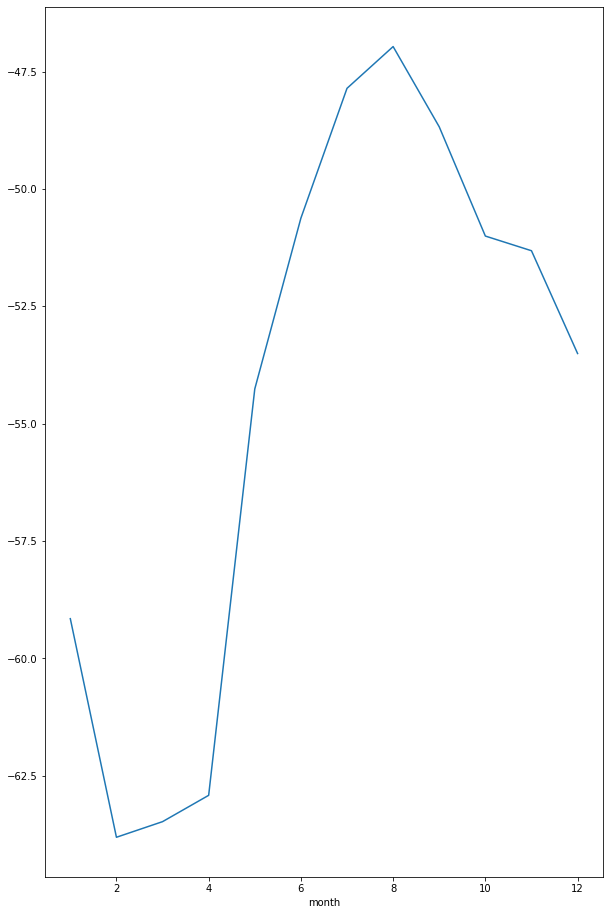

In [12]:
plt_HF_reg(0,10,80,100)#wtio


TypeError: IQR_plot() missing 1 required positional argument: 'lon1'

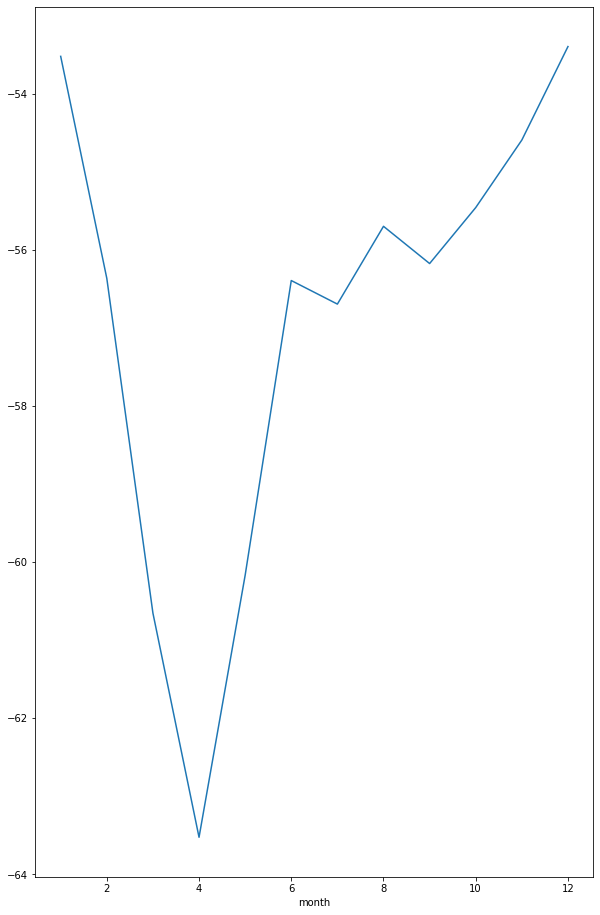

In [13]:
plt_HF_reg(-10,10,50,70)#wtio
plt.title('a) WTIO')

/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/na

Text(0.5, 1.0, 'b) SETIO')

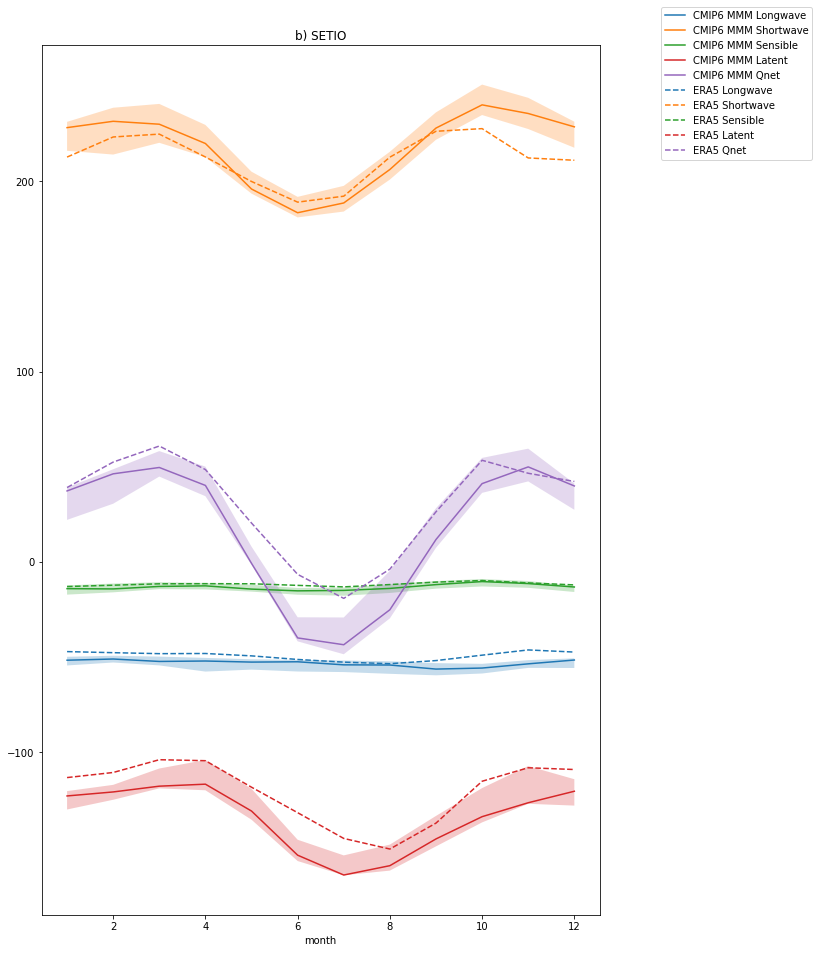

In [12]:
plt_HF_reg(-10,0,90,110)#SETIO
plt.title('b) SETIO')

SETIO region has more latent heat loss throughout the year, and in times of cool bias/ qnet bias (JJAS). At this time too there is a slight bias in reduced SW, indicating decreased cloud cover associated with lwoer SST and higher wind speed
###Check wind speed compaerd to ERA5 in this region

/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/na

Text(0.5, 1.0, 'c) Arabian Sea')

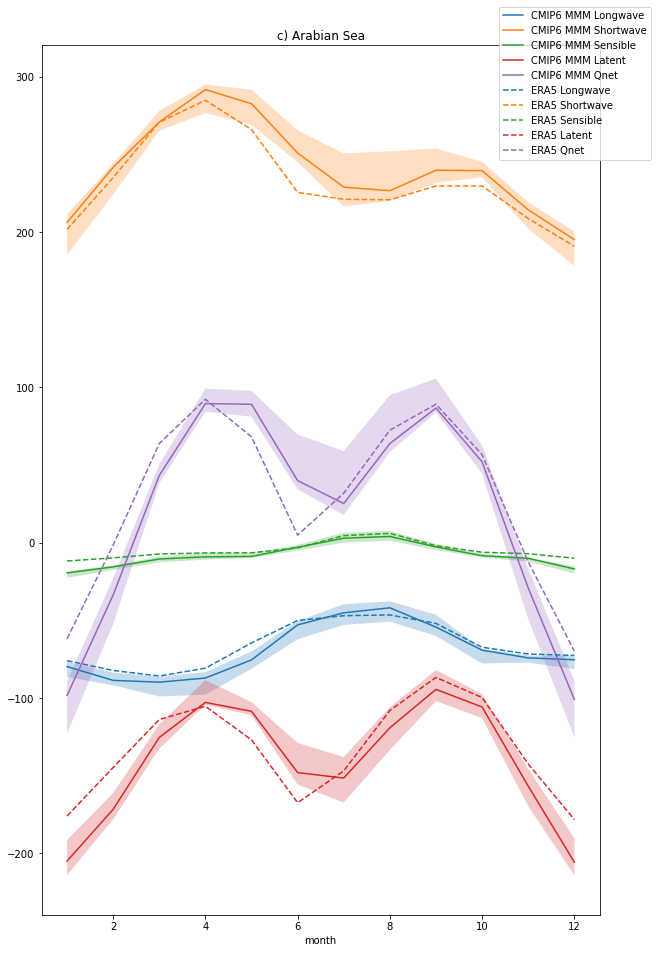

In [13]:
plt_HF_reg(10,20,50,70)#ARABIAN SEA
plt.title('c) Arabian Sea')

QNET has an overall cool bias in Nov to March. Increased Latent heta loss due to higher wind speed is repossnible for htis. 

In [ ]:
plt_HF_reg(-10,10,50,70)#WTIO

In [14]:
#load in ERA5 wind speed (***from windstress)
e5_WS = xr.open_dataarray("/g/data/e14/sm2435/ERA5/clim/ERA5_wspd.nc")


In [15]:
#load in CMIP6 wind speed (***from windstress)
outdir = '/g/data/e14/sm2435/CMIP6_HB/'#dict with file names
W={}
for model in os.listdir(outdir):
    #go thorugh all varis
    if model in ['NESM3']:
        pass
    else:
        mod={}
        #input file
        inp_files = (os.path.join(outdir, model, str(model+"_wspd.nc")))
        try:
            #load in file
            var = xr.open_dataarray(inp_files)
            #put into dict
            W[model]=var

        except Exception as e:
            print(e)
            pass

for i, model in enumerate(W.keys()):
    w=W[model]
    w=w.assign_coords({'model':model})
    #now turn all these variables into an array
    if i == 0:
        wM = w
    else:
        wM = xr.concat([wM, w], dim = 'model')


[Errno 2] No such file or directory: b'/g/data/e14/sm2435/CMIP6_HB/not_full/not_full_wspd.nc'


In [16]:
def plot_wind(lat, lat1, lon, lon1):
    plt.figure(figsize = (12,8))
    get_region(wM, lat, lat1, lon, lon1).median('model').plot(label = 'CMIP6 MMM wspd')
    IQR_plot(wM, lat, lat1, lon, lon1)
    get_region((e5_WS), lat, lat1, lon, lon1).plot(label = 'ERA5 wspd', c= 'tab:orange', ls = '--')
    plt.legend()
    return

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


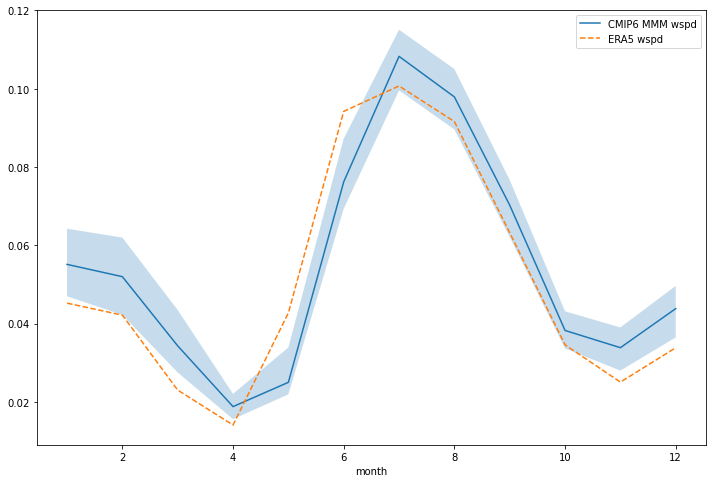

In [30]:
plot_wind(-10,10,50,70)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


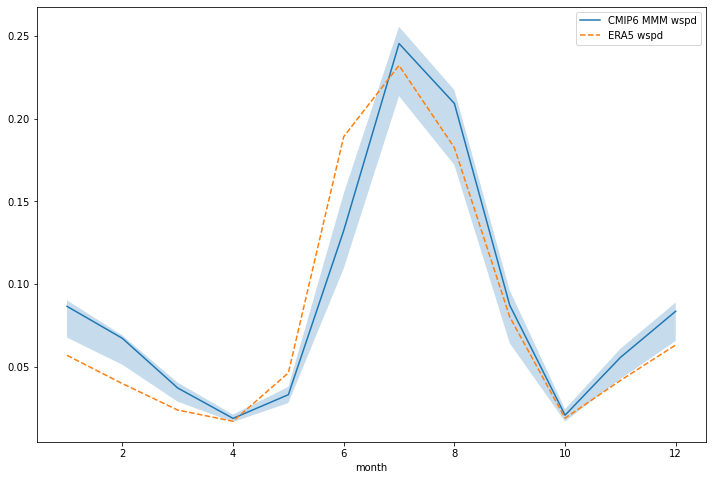

In [31]:
plot_wind(10,20,50,70)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


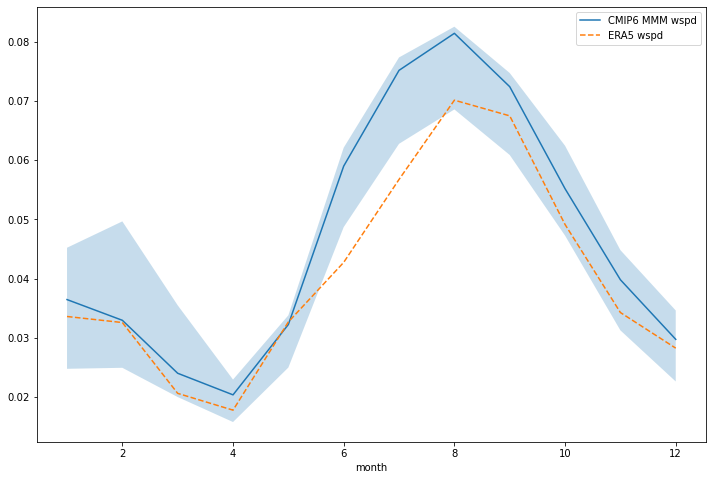

In [32]:
plot_wind(-10,0,90,110)

In [21]:
#lets look at intermodel correlation betwene wind speed and wind components to latent heat flux. Also do latent heat flux to net heat
def linear_trend(x, y):
    pf = np.polyfit(x, y, 1)
    return xr.DataArray(pf[0])
def regress(var1, var2):
    slope = xr.apply_ufunc(linear_trend,
                        var1, var2,
                        vectorize=True,
                        dask = 'parallelized',
                        input_core_dims=[['model'], ['model']],# reduce along 'model'
                        )
    return slope

In [33]:
def get_corrreg_HF(var1, var2, lat, lat1, lon, lon1):
    var1 = get_region(var1, lat, lat1, lon, lon1)
    var2 = get_region(var2, lat, lat1, lon, lon1)
    #now regress them in across models
    reg = regress(var1, var2)#.assign_coords({"regress":"r"})
    #reg.imshow()
    return reg


In [57]:
test = get_corrreg_HF(-1*lhm, wM, -10,0,90,110)

In [58]:
test

<xarray.DataArray (month: 12)>
array([-5.49229820e-04,  2.74110523e-04,  6.25754422e-04, -3.48748901e-05,
       -1.19133891e-04, -2.15756155e-04, -8.20717804e-05, -1.13087803e-04,
       -7.90363430e-05,  1.63779703e-04, -6.48152640e-05, -1.81928677e-04])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

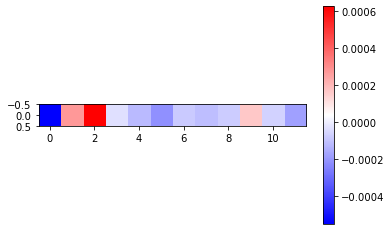

In [59]:
plt.imshow([test.values], cmap = 'bwr')#, vmin = -1e-3, vmax = 1e-3)
plt.colorbar()

In [95]:
from scipy.stats import pearsonr

In [77]:
def get_corrreg_HF(var1, var2, lat, lat1, lon, lon1):
    var1 = get_region(var1, lat, lat1, lon, lon1)
    var2 = get_region(var2, lat, lat1, lon, lon1)
    #now regress them in across models
    reg = regress(var1, var2)#.assign_coords({"regress":"r"})
    #reg.imshow()
    cD= np.apply_along_axis(correlate_1d, axis=0, arr=var1, ts2=var2)
    return reg, cD


In [ ]:
def correlate_1d(ts1, ts2):
    return pearsonr(ts1, ts2)

In [118]:
ts1 = get_region(lhm, 10,20,50,70)
ts2 = get_region(wM, 10,20,50,70)

In [119]:
def multi_apply_along_axis(func1d, axis, arrs, *args, **kwargs):
    """
    Given a function `func1d(A, B, C, ..., *args, **kwargs)`  that acts on 
    multiple one dimensional arrays, apply that function to the N-dimensional
    arrays listed by `arrs` along axis `axis`
    
    If `arrs` are one dimensional this is equivalent to::
    
        func1d(*arrs, *args, **kwargs)
    
    If there is only one array in `arrs` this is equivalent to::
    
        numpy.apply_along_axis(func1d, axis, arrs[0], *args, **kwargs)
        
    All arrays in `arrs` must have compatible dimensions to be able to run
    `numpy.concatenate(arrs, axis)`
    
    Arguments:
        func1d:   Function that operates on `len(arrs)` 1 dimensional arrays,
                  with signature `f(*arrs, *args, **kwargs)`
        axis:     Axis of all `arrs` to apply the function along
        arrs:     Iterable of numpy arrays
        *args:    Passed to func1d after array arguments
        **kwargs: Passed to func1d as keyword arguments
    """
    # Concatenate the input arrays along the calculation axis to make one big
    # array that can be passed in to `apply_along_axis`
    carrs = numpy.concatenate(arrs, axis)
    
    # We'll need to split the concatenated arrays up before we apply `func1d`,
    # here's the offsets to split them back into the originals
    offsets=[]
    start=0
    for i in range(len(arrs)-1):
        start += arrs[i].shape[axis]
        offsets.append(start)
            
    # The helper closure splits up the concatenated array back into the components of `arrs`
    # and then runs `func1d` on them
    def helperfunc(a, *args, **kwargs):
        arrs = numpy.split(a, offsets)
        return func1d(*[*arrs, *args], **kwargs)
    
    # Run `apply_along_axis` along the concatenated array
    return numpy.apply_along_axis(helperfunc, axis, carrs, *args, **kwargs)

In [120]:
import numpy


In [125]:
corr, p  = multi_apply_along_axis(pearsonr, 0, [-1*ts1, ts2])

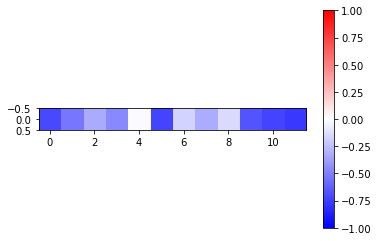

In [126]:
plt.imshow([corr], vmin = -1, vmax = 1, cmap='bwr')
plt.colorbar()

In [127]:
p

array([4.19177335e-04, 1.48516973e-02, 1.56532240e-01, 3.96347414e-02,
       9.46449278e-01, 2.28407502e-04, 4.73752967e-01, 1.66066680e-01,
       5.44849874e-01, 1.33051391e-03, 2.64722472e-04, 5.65130839e-05])

In [116]:
new = np.where(p<0.05)

In [117]:
new

(array([0, 2]),)

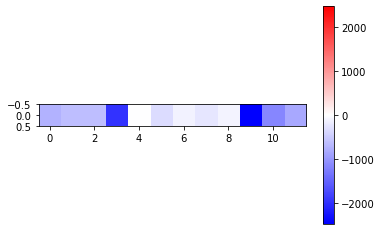

In [134]:
plt.imshow([regress(ts2, -1*ts1)],cmap = 'bwr', vmin = min(regress(ts2, -1*ts1)), vmax = -1*min(regress(ts2, -1*ts1)) )
plt.colorbar()

In [135]:
ts1 = get_region(lhm, -10,0,90,110)
ts2 = get_region(wM, -10,0,90,110)

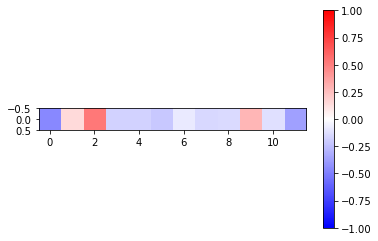

In [136]:
corr, p  = multi_apply_along_axis(pearsonr, 0, [-1*ts1, ts2])
plt.imshow([corr], vmin = -1, vmax = 1, cmap='bwr')
plt.colorbar()

In [137]:
p

array([0.03943565, 0.54925414, 0.01607262, 0.45463734, 0.45225527,
       0.36231292, 0.73160678, 0.51074312, 0.55149244, 0.21867044,
       0.60090913, 0.10550653])

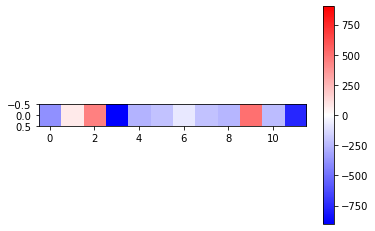

In [138]:
plt.imshow([regress(ts2, -1*ts1)],cmap = 'bwr', vmin = min(regress(ts2, -1*ts1)), vmax = -1*min(regress(ts2, -1*ts1)) )
plt.colorbar()